In [ ]:
# A model to simultate the diffusion of negative sentiment among Apple traders on social network. In particular, we use a reddit network
# built with 5 months data (from 01/2015 to 05/2015) as topology. The diffusion is led by sis model and trust among users. 
# This notebook is made of three parts: Model creation, Calibration, Validation.

### MODEL CREATION 

In [1]:
# Model design
import agentpy as ap
import networkx as nx 
import random 
import numpy as np
import pandas as pd
from itertools import count
from colour import Color 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

# Data analysis
from sklearn.metrics import mean_squared_error

In [2]:
# graph=nx.barabasi_albert_graph(882,2)

# Neg=int(len(graph.nodes)*0.607595)
# Pos=len(graph.nodes)-Neg
# sentiment_data = [0] * Pos + [1] * Neg
# from random import shuffle
# shuffle(sentiment_data)

# node_sentiment=[]
# for node in list(graph.nodes):
#     node_sentiment.append(np.sum(random.choices([1,0], cum_weights = (0.607595*100,100))))

# nodes=list(graph.nodes)
# dictionary = dict(zip(nodes, node_sentiment))

# #Metto l'attributo di sentiment nella rete
# nx.set_node_attributes(graph, dictionary, "Sentiment")

In [ ]:
# Upload the network

graph = nx.read_graphml(r"C:\Tempor\Reddit\network\amazon_network_5_months_right_sentiment.graphml")
sentiment=nx.get_node_attributes(graph, 'Sentiment')
sentiment_data=pd.DataFrame(sentiment.items())[1]

#Centrality
centrality = nx.katz_centrality_numpy(graph)
centrality_data=list(centrality.values())
c=centrality_data/np.max(centrality_data)

#### Network analysis

In [37]:
average_degree = round(sum(dict(graph.degree()).values()) / graph.number_of_nodes(),2)

# Print the result
print(f"The average degree is: {average_degree}")

The average degree is: 2.53


In [ ]:
nodelist = list(graph.nodes)
A = nx.to_numpy_array(graph, nodelist=nodelist)

In [41]:
import powerlaw as pwl
from scipy.stats import chisquare

Alpha: 2.779739789278731
Minimum Degree (xmin): 1.0


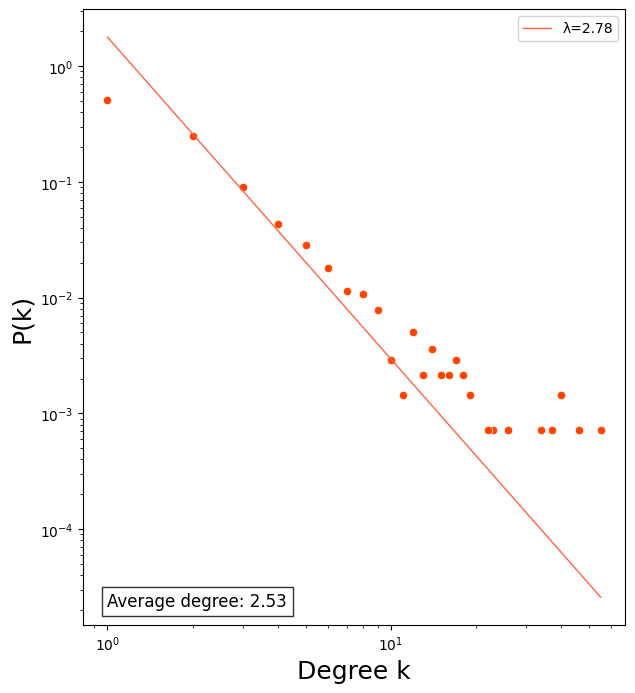

In [ ]:
# Degree distribution
import powerlaw

degree_per_node = graph.degree(graph.nodes, weight="weight")
node_degree=list(degree_per_node)
degree2=pd.DataFrame(node_degree, columns=["author","degree"])
degree_freq=(degree2["degree"].value_counts())/len(graph)

# Assuming you already have 'graph' and 'degree_per_node'
degree_per_node = graph.degree(graph.nodes, weight="weight")
node_degree = list(degree_per_node)

# Create DataFrame
degree2 = pd.DataFrame(node_degree, columns=["author", "degree"])
# degree2=degree2[degree2['degree']!=1]
# Calculate frequency of degrees
degree_freq = (degree2["degree"].value_counts())/len(graph)
# degree_freq = degree_freq.iloc[1:]

# Fit the power law
fit = powerlaw.Fit(degree2["degree"], xmin=1)

# Print the alpha exponent and other fit parameters
print(f'Alpha: {fit.alpha}')
print(f'Minimum Degree (xmin): {fit.xmin}')

# Plot the empirical degree distribution using seaborn
plt.figure(figsize=(7, 8))
sns.scatterplot(x=degree_freq.index, y=degree_freq, marker='o', color='orangered')

# Adjust the scale to log-log
plt.xscale('log')
plt.yscale('log')

# Customize labels with increased font size
plt.xlabel('Degree k', fontsize=18)
plt.ylabel('P(k)', fontsize=18)

# Plot the fitted power law
# x = range(min(degree_freq.index), max(degree_freq.index) + 1)
# y = [(i ** (-fit.alpha)) * (degree_freq.max()) for i in x]
# plt.plot(x,y,'o', color='orangered')

fit.power_law.plot_pdf(color='tomato', linestyle='-', linewidth=1, label=f'λ={fit.alpha:.2f}')
plt.text(1,0.00002,'Average degree: '+ str(average_degree), fontsize = 12, va='bottom',
         bbox = dict(facecolor = 'white', alpha = 0.8))
plt.legend()

# expected_freq = [(i ** (-fit.alpha)) * degree_freq.max() for i in degree_freq.index]
# chi2, p_value = chisquare(f_obs=degree_freq, f_exp=expected_freq)

# plt.plot(x, y, label=f'λ={fit.alpha:.2f}', color='tomato')
# plt.text(1,0.06,'Average degree: '+ str(average_degree), fontsize = 12, 
#          bbox = dict(facecolor = 'white', alpha = 0.8))

# plt.text(1, 0.03, f'Chi-Square: {chi2:.2f}', fontsize=12,
#          bbox=dict(facecolor='white', alpha=0.8))
plt.legend()

# Show plot
plt.draw()

# Optionally save the plot
# plt.savefig(r"C:\Users\barat\A_Dottorato\Simulazioni\Amazon_real_net_degree.png")


In [43]:
import powerlaw as pwl

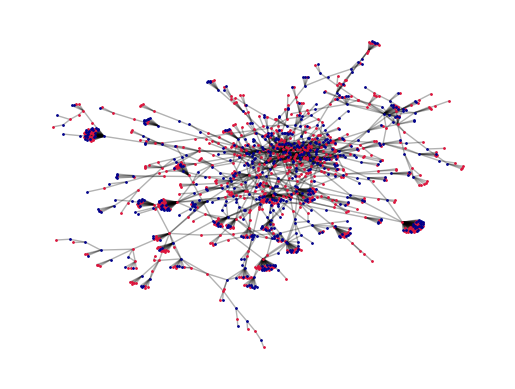

In [ ]:
# Here we assign different colors to the nodes according to their sentiment

sentimento=list(nx.get_node_attributes(graph,'Sentiment').values())
nodi=list(graph.nodes)
positivi=[]
colori_pos=[]
negativi=[]
colori_neg=[]
for i in range(len(sentimento)):
    if (sentimento[i]==0):
        positivi.append(nodi[i])
        colori_pos.append(1)
    else:
        negativi.append(nodi[i])
        colori_neg.append(0)

# get unique groups
sentiments = set(nx.get_node_attributes(graph,'Sentiment').values())
mapping = dict(zip(sorted(sentiments),count()))
nodes = graph.nodes()
colors = [mapping[graph.nodes[n]['Sentiment']] for n in nodes]

# drawing nodes and edges separately so we can capture collection for colobar
pos = nx.spring_layout(graph)
ec = nx.draw_networkx_edges(graph, pos, alpha=0.3)
nx.draw_networkx_nodes(graph, pos, nodelist=negativi, node_size=1, node_color="#DC143C", label=('Negative sentiment agents'))
nx.draw_networkx_nodes(graph, pos, nodelist=positivi, node_size=1, node_color="darkblue", label=('Positive sentiment agents'))
# nx.draw_networkx_nodes(graph, pos, nodelist=negativi, node_size=1, node_color="darkgreen", label=('Negative sentiment agents'))
# nx.draw_networkx_nodes(graph, pos, nodelist=positivi, node_size=1, node_color="darkgreen", label=('Positive sentiment agents'))
plt.axis('off')
# plt.show(block=False)
# plt.legend(loc='lower right')
# plt.savefig(r"C:\Users\barat\A_Dottorato\Simulazioni\Amazon_real_net_sentiment.png")
plt.draw()

#### Model definition using AgentPy

In [134]:
# import EoN

In [135]:
# # initial_infecteds = [random.choice(list(graph))]
# for counter in range(10):
#     t, S, I = EoN.fast_SIS(graph, tau=0.277778, gamma=0.054444, tmax = 70, initial_infecteds=negativi)
#     if counter == 0:
#         plt.plot(t, I/882, color = 'k', alpha=0.3, label='Simulation')
#     plt.plot(t, I/882, color = 'k', alpha=0.3)


In [ ]:
# Definition of the agents, representing Reddit users, and their behaviours.
class Person(ap.Agent):
    
    def setup(self):  
        
        #S=0, I=1, R=2
        self.condition=0
        
        #Centrality measure
        self.katz=0

        #Trust che gli altri hanno nei miei confronti
        self.other_trust=np.repeat(0.5,len(graph.nodes))

    def S_behaviour_become_infected(self):

        
        #infection
        nb_hosts = 0
        nb_hosts_infected=0
        nb_neigh_sus=0
        nb_neigh_inf=0


        if (len(list(self.network.neighbors(self)))!=0):
            for n in self.network.neighbors(self):
                nb_hosts+=1
                if(n.condition ==1):
                    nb_hosts_infected+=n.other_trust[self.id-1]
                    nb_neigh_inf += 1
                if (n.condition == 0):
                    nb_neigh_sus += 1
            rate = nb_hosts_infected/nb_hosts 
            # self.condition = np.sum(random.choices([1,0], cum_weights = (min(self.p.infection_chance*rate*100,100),100)))
            self.condition = np.sum(random.choices([1,0], cum_weights = (self.p.infection_chance*rate*100,100)))
            if (nb_neigh_sus>nb_neigh_inf):
                avg_cond=0
            else:
                avg_cond=1
            if (self.condition == avg_cond):
                for n in self.network.neighbors(self):
                    n.other_trust[self.id-1]+=0.000000001
                    if(n.condition == avg_cond):
                    #     n.other_trust[self.id-1]+=0.1
                    # else:
                    #     n.other_trust[self.id-1]-=0.1
                        n.other_trust[self.id-1]=min(n.other_trust[self.id-1]+self.p.alpha,1)
                    else:
                        n.other_trust[self.id-1]=max(n.other_trust[self.id-1]-self.p.alpha,0)
            if (self.condition != avg_cond):
                for n in self.network.neighbors(self):
                    n.other_trust[self.id-1]+=0.000000001
                    if(n.condition == avg_cond):
                    #     n.other_trust[self.id-1]+=0.1
                    # else:
                    #     n.other_trust[self.id-1]-=0.1
                         n.other_trust[self.id-1]=min(n.other_trust[self.id-1]+self.p.alpha,1)
                    else:
                        n.other_trust[self.id-1]=max(n.other_trust[self.id-1]-self.p.alpha,0)
      
    def I_behaviour_become_susceptible(self):
                               
        #becoming susceptible
        self.condition = np.sum(random.choices([0,1], cum_weights = (self.p.susceptibility_chance*100,100)))

In [ ]:
# Definition of the model. We assign the network as environment where agents live, 
# call the behaviours and record the results.
class Sentiment_diffusion(ap.Model):
    
    def setup(self):
        self.shares=100
        
        #Create agents and network
        self.users = ap.AgentList(self, self.p.evolving_population, Person)
        self.network = self.users.network = ap.Network(self, graph)
        self.network.add_agents(self.users, self.network.nodes)

        #Infection according to initial sentiment
        #If Sentiment=0=pos then agent is not infected, if Sentiment=1=neg then agent is infected.
        for i in range(len(self.users)):
            if (self.users[i].condition!=sentiment_data[i]):
                self.users[i].condition=1
                
        #Katz centrality
        # for i in range(len(self.users)):
        #     self.users[i].katz=c[i]
    
             
    def update(self):    
        # Record share of agents with each condition
        for i, c in enumerate(('S', 'I')):
            n_users = len(self.users.select(self.users.condition == i))
            self[c] = n_users / self.p.evolving_population 
            self.record(c)
            
        # Record demand
        self['shares']=self.shares
        self.record('shares')

        
    def step(self):    
        #We call 'S_behaviour_become infected' and 'I_behaviour_become recovered' according to Persons conditions
        self.users.select(self.users.condition == 0).S_behaviour_become_infected()
        self.users.select(self.users.condition == 1).I_behaviour_become_susceptible()

        
    def end(self):     
        # Record final evaluation measures
        self.report('Total share infected', self.I) 
        self.report('Peak share infected', max(self.log['I']))

### CALIBRATION

In [342]:
df=pd.read_json(r'C:\Tempor\reddit\sentiment_data\apple\apple_sentiment_series.json')
sentiment=df['neg']

# Let's consider just a part of our dataset, we leave out the last two month so we will try to predict them
df_train=df[0:68]
sentiment_train=sentiment[0:68]

In [ ]:
# First run (without it the multi simulation doesn't work, I don't know exactly why).
parameters = {  
    'seed': 42,
    'evolving_population': len(graph.nodes),
    'infection_chance': 0.46,
    # 'recovery_chance': 0.09,
    'susceptibility_chance':0.09,
    'alpha':0.072,
    'steps':76
}

model = Sentiment_diffusion(parameters)
results = model.run(steps=model.p.steps) 

Completed: 76 steps
Run time: 0:00:01.161873
Simulation finished


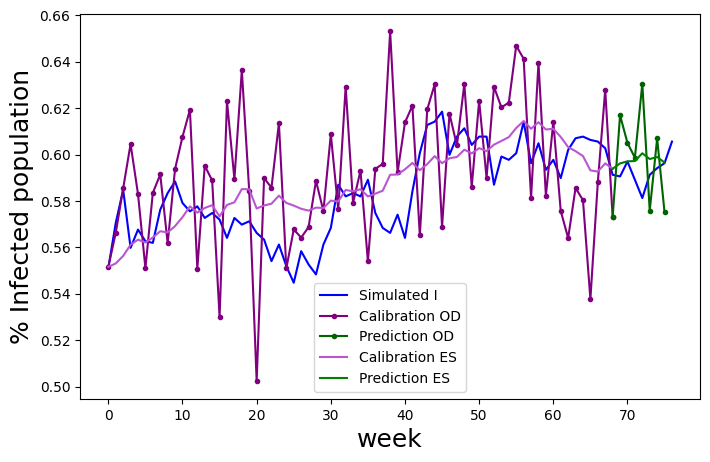

In [ ]:
data=results.variables.Sentiment_diffusion
S=data.S
I=data.I
time=data.index.get_level_values('t')

data=sentiment

# Exponential Smoothing
alpha = 0.1  # Smoothing factor (adjust for desired responsiveness)
smoothed_data = np.zeros_like(data)  # Initialize smoothed data array
smoothed_data[0] = data[0]  # Seed the first value
for i in range(1, len(data)):
    smoothed_data[i] = alpha * data[i] + (1 - alpha) * smoothed_data[i-1]

plt.figure(figsize=(8,5))
plt.plot(time,I, label='Simulated I', color='b')
plt.plot(time[0:69], sentiment[0:69], 'o-', markersize=3, label='Calibration OD', color='purple')
plt.plot(time[68:76], sentiment[68:76], 'o-', markersize=3, label='Prediction OD', color='darkgreen')
plt.plot(time[0:69], smoothed_data[0:69], '-', markersize=3, label='Calibration ES', color='mediumorchid')
plt.plot(time[68:76], smoothed_data[68:76], '-', markersize=3, label='Prediction ES', color='green')
plt.ylabel('% Infected population', fontsize=18)
plt.xlabel('week', fontsize=18)
plt.legend()
plt.draw()

# plt.savefig(r"C:\Users\barat\A_Dottorato\Simulazioni\una_realizzazione_3.png")

#### Sentiment time series visualization

In [343]:
df_Google=pd.read_json(r'C:\Tempor\reddit\sentiment_data\google\google_sentiment_series.json')
sentiment_Google=df_Google['neg']
# sentiment_Google=sentiment_Google[0:68]

df_Amazon=pd.read_json(r'C:\Tempor\reddit\sentiment_data\amazon\amazon_sentiment_series.json')
sentiment_Amazon=df_Amazon['neg']
# sentiment_Amazon=sentiment_Amazon[0:68]

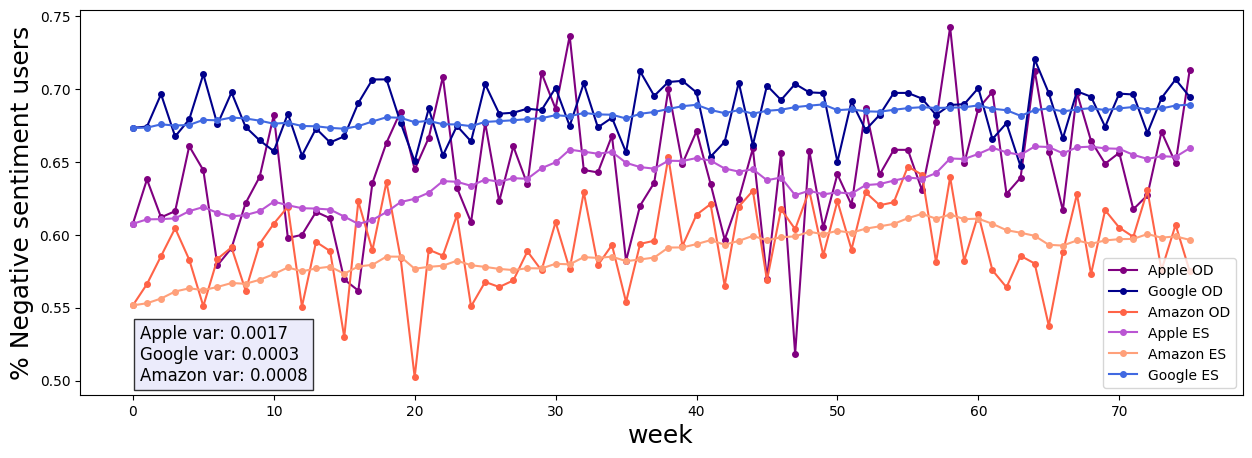

In [ ]:
alpha = 0.1

smoothed_data_a = np.zeros_like(sentiment_Amazon)  # Initialize smoothed data array
smoothed_data_a[0] = sentiment_Amazon[0]  # Seed the first value
for i in range(1, len(sentiment_Amazon)):
    smoothed_data_a[i] = alpha * sentiment_Amazon[i] + (1 - alpha) * smoothed_data_a[i-1]

smoothed_data_g = np.zeros_like(sentiment_Google)  # Initialize smoothed data array
smoothed_data_g[0] = sentiment_Google[0]  # Seed the first value
for i in range(1, len(sentiment_Google)):
    smoothed_data_g[i] = alpha * sentiment_Google[i] + (1 - alpha) * smoothed_data_g[i-1]

# Plot comparison
plt.figure(figsize=(15,5))
plt.plot(data, 'o-', markersize=4, label='Apple OD', color='purple')
plt.plot(sentiment_Google, 'o-', markersize=4, label='Google OD', color='darkblue')
plt.plot(sentiment_Amazon, 'o-', markersize=4, label='Amazon OD', color='tomato')
plt.plot(smoothed_data, 'o-', markersize=4, label='Apple ES', color='mediumorchid')
plt.plot(smoothed_data_a, 'o-', markersize=4, label='Amazon ES', color='lightsalmon')
plt.plot(smoothed_data_g, 'o-', markersize=4, label='Google ES', color='royalblue')
plt.xlabel('week', fontsize=18)
plt.ylabel('% Negative sentiment users', fontsize=18)
plt.text(0.5,0.5,'Apple var: 0.0017 \nGoogle var: 0.0003 \nAmazon var: 0.0008', fontsize = 12, 
         bbox = dict(facecolor = 'lavender', alpha = 0.8))
plt.legend()
plt.draw()

# plt.savefig(r"C:\Users\barat\A_Dottorato\Simulazioni\3_Sentiment_series_smoothed.png")

In [60]:
v_apple=np.var(data)
v_google=np.var(sentiment_Google)
v_amazon=np.var(sentiment_Amazon)

#### Multiple simulation for calibration

In [ ]:
parameters_multi = dict(parameters)
parameters_multi.update({
    'infection_chance': (0.000001,1),
    'susceptibility_chance':(0.000001,1),
    'alpha': ap.Range(0.01,0.019)
    # 'infection_chance':  0.01,
    # 'susceptibility_chance':0.001
})

sample = ap.Sample(parameters_multi, n=10, randomize=False)
exp = ap.Experiment(Sentiment_diffusion, sample, iterations=100, record=True)
results = exp.run(n_jobs=-1, verbose=10)
# results.save()
data=results.variables.Sentiment_diffusion

In [ ]:
# Choose the best curve using MSE

var=[]
parameters=[]
best_parameters=[]
a=np.zeros(68)
for i in range(len(results.parameters.sample)):
    for j in range(10):
        I_current_sample=I[I.index.get_level_values('sample_id')==i]
        I_current=I_current_sample[I_current_sample.index.get_level_values('iteration')==j]
        variance=mean_squared_error(I_current,sentiment[0:68])*(len(I_current)+1)
        var.append(variance)
        parameters.append([i,j])

    d={'var':var, 'parameters':parameters}
    df=pd.DataFrame(data=d)

    best_sample=df[df['var']==np.min(df['var'])]['parameters']
    best_parameters=results.parameters.sample[results.parameters.sample.index==best_sample.iloc[0][0]]
    best_mse=df['var'][best_sample.index]

print(best_parameters, best_mse)

### VALIDATION

In [ ]:
# Multi run but with the value arriving from the calibration, so only iteration of the same combination of parameters
# The parameters combination is the outcome of "best parameters" in the previous cell.

parameters_val = {  
    'seed':42,
    'evolving_population': len(graph.nodes),
    'infection_chance': 0.05 ,
    'susceptibility_chance':0.01,
    'alpha':0.015,
    
    'steps':76
}

model_val = Sentiment_diffusion(parameters_val)
results_val = model_val.run(steps=model_val.p.steps) 

parameters_multi_val = dict(parameters_val)
parameters_multi_val.update({
    'infection_chance': 0.05,
    'susceptibility_chance':0.01,
    'alpha':0.015
})

sample = ap.Sample(parameters_multi_val)

exp = ap.Experiment(Sentiment_diffusion, sample, iterations=100, record=True)
results_val = exp.run(n_jobs=-1, verbose=10)
# results_val.save()

data_val=results_val.variables.Sentiment_diffusion


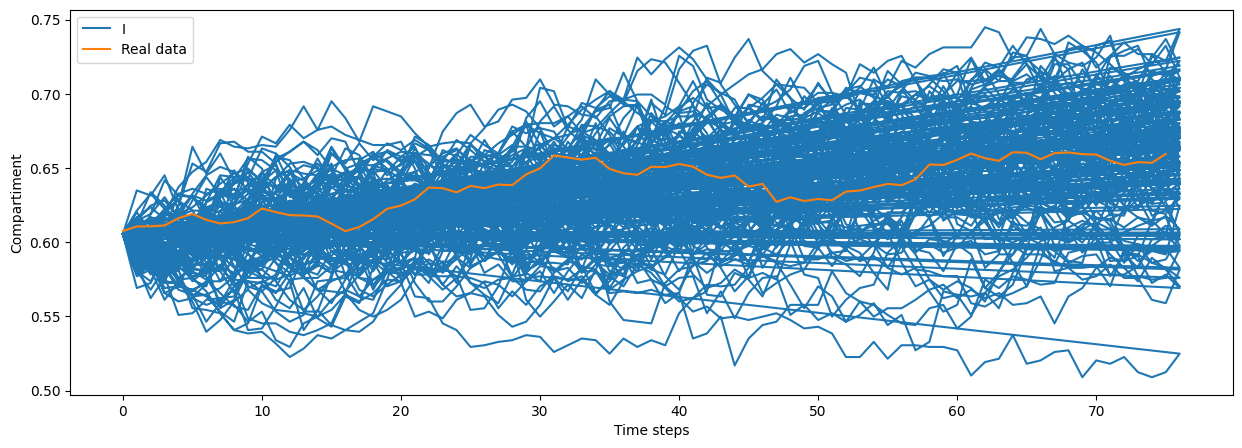

In [202]:
S=data_val.S
I=data_val.I
time=data_val.index.get_level_values('t')

plt.figure(figsize=(15,5))
# plt.plot(time, I, 'o-', markersize=1, label='I')
plt.plot(time, I, label='I')
plt.plot(time[0:76], smoothed_data, label='Real data')
plt.ylabel('Compartiment')
plt.xlabel('Time steps')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(8,5))

sns.lineplot(
    data=results_val.arrange_variables(),
    x='t',
    y='I',
    # hue='iteration',
    legend=True,
    errorbar=('sd',3),
    # palette=['lavender']
    color='#C1B4FF',
    label='3-sigma halo'
)
sns.lineplot(
    data=results_val.arrange_variables(),
    x='t',
    y='I',
    errorbar=('se',2),
    color='b',
    label='Mean curve and 95% confidence interval'
)


# sns.lineplot(
#     data=results_val.arrange_variables(),
#     x='t',
#     y='I',
#     color='b'
# )
# plt.errorbar(time[0:68], sentiment[0:68], yerr=df_err['Propagation errors'][0:68], fmt='o-',label='Train set', color='purple')
# plt.errorbar(time[67:76], sentiment[67:76], yerr=df_err['Propagation errors'][67:76], fmt='o-',label='Test set', color='darkgreen')
# plt.plot(time[0:69], smoothed_data[0:69], 'o-', label='Train set', color='purple')
# plt.plot(time[68:76], smoothed_data[68:76], '-o', label='Test set', color='darkgreen')
# plt.plot(time[0:69], sentiment[0:69], 'o-', label='Apple OD - calibration', color='purple')
# plt.plot(time[68:76], sentiment[68:76], '-o', label='Apple OD - prediction', color='darkgreen')
plt.plot(time[0:76], smoothed_data[0:76], 'o-', markersize=4, label='Amazon ES', color='mediumorchid')
# plt.plot(time[68:76],smoothed_data[68:76], 'o-', markersize=4, label='Apple ES - prediction', color='mediumseagreen')
plt.xlabel("week", fontsize=18)
plt.ylabel("% Infected population", fontsize=18)
plt.legend()
plt.draw()

# plt.savefig(r"C:\Users\barat\A_Dottorato\Simulazioni\Amazon_500.png")